In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate

import shap
import xgboost as xgb

In [2]:
shap.initjs()

In [3]:
df = pd.read_csv('../Data/Processed Dataset Train')

In [4]:
df.insert(31, "Media", np.where((df["Photo Count"] > 0) | (df["Video Count"] > 0) | (df["GIF Count"] > 0), 1, 0))
df.insert(32, "Emotion Score", df["Negative Score"] + df["Positive Score"])
df.insert(33, "Photo", np.where(df["Photo Count"] > 0, 1, 0))
df.insert(34, "Video", np.where(df["Video Count"] > 0, 1, 0))
df.insert(35, "GIF", np.where(df["GIF Count"] > 0, 1, 0))

In [5]:
df.iloc[:, :38].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46289 entries, 0 to 46288
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                46289 non-null  int64  
 1   date                              46289 non-null  object 
 2   hour of tweet                     46289 non-null  int64  
 3   time of day                       46289 non-null  object 
 4   Early Morning Count               46289 non-null  int64  
 5   Morning Count                     46289 non-null  int64  
 6   Noon Count                        46289 non-null  int64  
 7   Eve Count                         46289 non-null  int64  
 8   Night Count                       46289 non-null  int64  
 9   Late Night Count                  46289 non-null  int64  
 10  user                              46289 non-null  object 
 11  user_followers                    46289 non-null  int64  
 12  Mont

In [6]:
useful_list = [24, 25, 26, 11, 12, 15, 17, 22, 23, 28, 29, 30, 31, 33, 34, 35, 36]

In [7]:
df_small = df.iloc[:, useful_list]

In [8]:
X = df_small.iloc[:, 3:].join(df.iloc[:, 37:])
y = df_small.iloc[:, 1]

In [9]:
X.columns

Index(['user_followers', 'Months Since Creation of Account', 'Negative Score',
       'Positive Score', 'Polarity Score_textblob',
       'Subjectivity Score_textblob', 'tweet_length', 'num_mentions',
       'num_hashtags', 'Media', 'Photo', 'Video', 'GIF', 'num_urls'],
      dtype='object')

Retweets partitioned into bins for discrete y outcome
- 0
- 1-5
- 6-20
- 21+

In [10]:
y_discrete = np.where(y == 0, 0,
             np.where((y >= 1) & (y <= 5), 1,
             np.where((y >= 6) & (y <= 20), 2, 3)))

In [11]:
pd.Series(y_discrete).value_counts()

0    28514
1    13803
2     2739
3     1233
dtype: int64

In [12]:
X_train, X_test, y_train, y_test, y_discrete_train, y_discrete_test = train_test_split(X, y, y_discrete, random_state = 0)

## XGBoost Tweedie Regression

In [13]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [14]:
params = {"objective":"reg:tweedie",'colsample_bytree': 1.0, 'learning_rate': 0.01,'gamma':1.5,'max_depth': 2,
 'subsample':0.6, 'reg_alpha': 0,'reg_lambda':1,'min_child_weight':5, 'tweedie_variance_power':1.5}

In [15]:
t0 = time.time()
bst = xgb.train(params, dtrain, num_boost_round = 1000)
t1 = time.time()
print(round(t1 - t0), 'seconds')

7 seconds


In [16]:
preds = bst.predict(dtest)
preds_int = np.round(preds).astype(int)

In [17]:
from sklearn.metrics import mean_tweedie_deviance
mean_tweedie_deviance(y_test, preds, power = 1.5)
#testing loss

5.036029755781521

In [18]:
preds_train = bst.predict(dtrain)
mean_tweedie_deviance(y_train, preds_train, power = 1.5)
#training loss

4.652749451804919

In [19]:
from sklearn.metrics import zero_one_loss
1 - zero_one_loss(y_test, preds_int)
#correctly predicts 31% of the test sample

0.31357469973213514

### Cross validation

In [48]:
def zero_one_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(preds).astype(int)
    return "0-1_Accuracy", 1 - zero_one_loss(labels, preds)

In [47]:
t0 = time.time()
scores = xgb.cv(params, dtrain, nfold = 5, metrics = 'tweedie-nloglik@1.5',
                num_boost_round = 1000, as_pandas = True, custom_metric = zero_one_accuracy)
t1 = time.time()
print(round(t1-t0, 'seconds'))

AssertionError: metric must be callable object for monitoring.  For builtin metrics, passing them in training parameter will invoke monitor automatically.

In [36]:
scores.iloc[-1]

train-tweedie-nloglik@1.5-mean    5.507468
train-tweedie-nloglik@1.5-std     0.023800
test-tweedie-nloglik@1.5-mean     5.657660
test-tweedie-nloglik@1.5-std      0.090780
train-asdf-mean                   0.317815
train-asdf-std                    0.003762
test-asdf-mean                    0.316857
test-asdf-std                     0.006426
Name: 999, dtype: float64

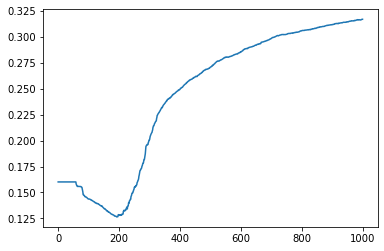

In [41]:
#plt.plot(scores["test-tweedie-nloglik@1.5-mean"])
plt.plot(scores["test-asdf-mean"])
plt.show()

### Model interpretation

In [49]:
explainer_tweedie = shap.TreeExplainer(bst)
shap_values_tweedie = explainer_tweedie.shap_values(X)

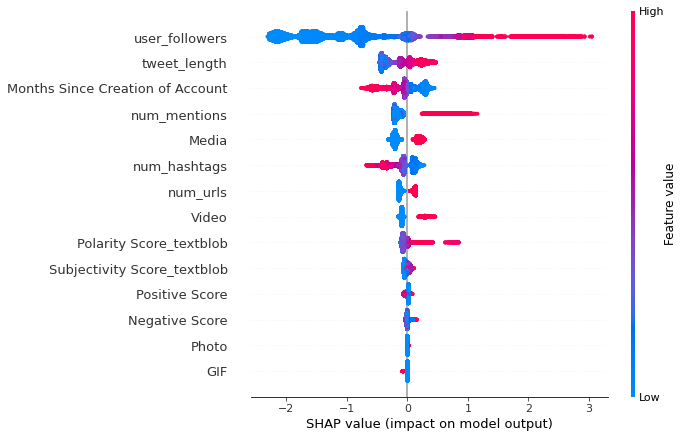

In [50]:
shap.summary_plot(shap_values_tweedie, X)

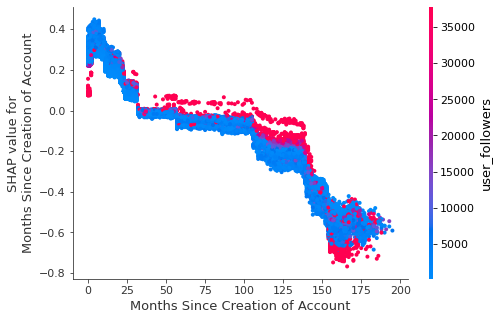

In [51]:
shap.dependence_plot('Months Since Creation of Account', shap_values_tweedie, X)

## XGBoost Discrete Outcome Bins Classification

In [53]:
dtrain_discrete = xgb.DMatrix(X_train, label = y_discrete_train)
dtest_discrete = xgb.DMatrix(X_test, label = y_discrete_test)

In [67]:
params = {'objective':'multi:softprob', 'num_class': 4}

In [68]:
t0 = time.time()
bst = xgb.train(params, dtrain_discrete, num_boost_round = 1000)
t1 = time.time()
print(round(t1-t0, 'seconds'))

KeyboardInterrupt: 